# Custom Augmentations

This notebook illustrates how to create new policies.

In [2]:
import os

import imgaug as ia
import imageio
from imgaug.augmentables.bbs import (
    BoundingBox,
    BoundingBoxesOnImage,
)
import numpy as np

In [3]:
os.chdir('../')

In [4]:
from bbaug.augmentations import augmentations
from bbaug.policies import policies

Load in the example image, bounding boxes and plot:

In [9]:
im = imageio.imread('./notebooks/data/example_dataset/images/dog_1.jpg')
bbs = BoundingBoxesOnImage(
    [
        BoundingBox(x1=42, x2=266, y1=71, y2=244),
        BoundingBox(x1=279, x2=341, y1=48, y2=71)
    ],
    im.shape
)

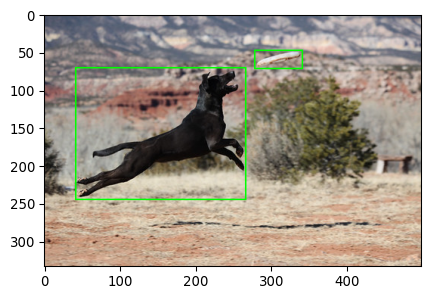

In [10]:
ia.imshow(bbs.draw_on_image(im, size=2))

## Custom Policies

If you wish to create custom policies you will need to create two things:
    1. Policy list
    2. Name to augmentation mapping

The policy list consists of a list of sub-policies. Within each sub-policy are namedtuple(s) consisting of the augmentation(s) in this sub-policy. The namedtuple takes on the following format:
  - **Name**: Name of the augmentation
  - **Probability**: Probability of augmentation being applied
  - **Magnitude**: The degree of the augmentation
  
All augmentations in `BBAug` are done by the [imgaug](https://imgaug.readthedocs.io/en/latest/index.html) package. Please refer to their docs for the full list of augmentations available. Let's create a up/down flip augmentation. 

In [11]:
import imgaug.augmenters as iaa

In [13]:
# Create the flip up / down augmentations method with default parameters
aug = iaa.Flipud()

In [15]:
# Apply the augmentation to the image
img_aug, bbs_aug = aug(image=im, bounding_boxes=bbs)

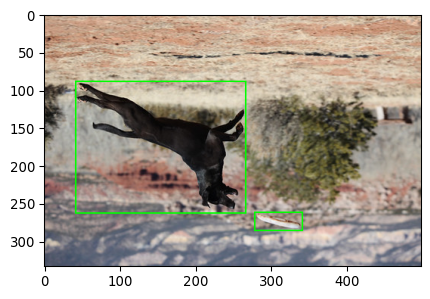

In [17]:
# Plot the augmented image with the bounding boxes
ia.imshow(bbs_aug.draw_on_image(img_aug, size=2))

We now have a flip up/down augmentation. Let's wrap this augmentation so it can be incorporated into `BBAug` as a policy. The augmentation is wrapped into a function and the augmentation is returned. Note, magnitude is not required here, but is  included to fit into the `BBAug` ecosystem. I've also added a translation augmentation as an additional augmentation.

In [28]:
def flip_up_down(magnitude: int) -> iaa.Flipud:
    return iaa.Flipud()

def translate(magnitude: int) -> iaa.Affine:
    return iaa.Affine(translate_px={'x': magnitude})

Next thing to do is to create the policy itself. Within the `policies` module is a namedtuple called `POLICY_TUPLE` to aid in the creation of the augmentation. This is required as the augmentations are accessed by their name attributes.

In [18]:
policies.POLICY_TUPLE('FlipUpDown', 1.0, 0)

policy(name='FlipUpDown', probability=1.0, magnitude=0)

In [22]:
policies.POLICY_TUPLE('Translate_X', 1.0, 50)

policy(name='Translate_X', probability=1.0, magnitude=50)

Create the policy:

In [23]:
policy = [
    [policies.POLICY_TUPLE('FlipUpDown', 1.0, 0), policies.POLICY_TUPLE('Translate_X', 1.0, 50)],
    [policies.POLICY_TUPLE('Translate_X', 1.0, 50)],
]

In [24]:
policy

[[policy(name='FlipUpDown', probability=1.0, magnitude=0),
  policy(name='Translate_X', probability=1.0, magnitude=50)],
 [policy(name='Translate_X', probability=1.0, magnitude=50)]]

The policy consists of a list of sub-policies, within each sub-policy are the augmentations in this sub-policy. Here, we create a policy with two sub-policies, one with two augmentations and the other only a single augmentation. The `FlipUpDown` augmentation has a probability of 1 meaning it will always be applied. You can add further sub-polices following the format above. If you wish to add further augmentations to a sub-policy append a new augmentation as a named tuple to the appropriate sub-policy. There must be at least 1 sub-policy in a policy list and and least 1 augmentation in each sub-policy.

With the policy list created, the next thing to do is to create a name to augmentation mapping. This is a dictionary with the key as the augmentation name and the value the reference to the augmentation method:

In [26]:
name_to_augmentation = {
    'FlipUpDown': flip_up_down,
    'Translate_X': translate
}

In [27]:
name_to_augmentation['FlipUpDown']

<function __main__.flip_up_down(magnitude: int) -> imgaug.augmenters.flip.Flipud>

That's it. To incorporate it into the policy container it can be done like so:

In [29]:
policy_container = policies.PolicyContainer(
    policy,
    name_to_augmentation=name_to_augmentation
)

You can access the augmentations in the policy container like so:

In [30]:
print(policy_container['FlipUpDown'])
print(policy_container['Translate_X'])

<function flip_up_down at 0x000001C0D0C99EE8>
<function translate at 0x000001C0D0CADA68>


Select a random sub-policy from our policy list:

In [46]:
random_policy = policy_container.select_random_policy()
random_policy

[policy(name='FlipUpDown', probability=1.0, magnitude=0),
 policy(name='Translate_X', probability=1.0, magnitude=50)]

Apply the randomly selected sub-policy with the policy container. Note, bounding boxes are passed a list of list of `ints` (pixels). With the format
`[x_min, y_min, x_max, y_max]`

In [47]:
bbs = [[42, 71, 266, 244], [279, 48, 341, 71]]
img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, im, bbs)

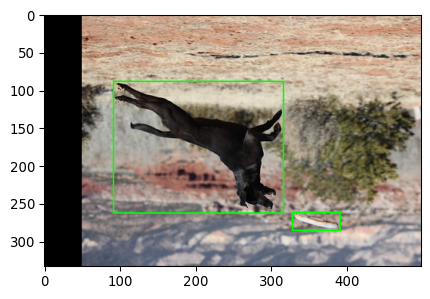

In [48]:
bbs_aug = BoundingBoxesOnImage([BoundingBox(*box) for box in bbs_aug], img_aug.shape) # Need to convert bounding boxes
ia.imshow(bbs_aug.draw_on_image(img_aug, size=2))

Augmentations such as translate also imply direction. In the above example we translate the image 50 pixels to the right. Passing a negative value will translate the image 50 pixels to the left. BBAug comes with a `negate` method wrapper to randomly assign a negative value to augmentations that imply direction:

In [49]:
@augmentations.negate
def randomly_negate(magnitude: int):
    return magnitude

In [50]:
for i in range(10):
    print(randomly_negate(50))

50
-50
-50
50
-50
-50
-50
50
50
-50


We can incorporate this into our policy like so:

In [51]:
def translate(magnitude: int) -> iaa.Affine:
    level = randomly_negate(magnitude)
    return iaa.Affine(translate_px={'x': level})

In [52]:
# Re-create the policy and name to augmentation
policy = [
    [policies.POLICY_TUPLE('FlipUpDown', 1.0, 0), policies.POLICY_TUPLE('Translate_X', 1.0, 50)],
]

name_to_augmentation = {
    'FlipUpDown': flip_up_down,
    'Translate_X': translate
}

In [62]:
# Create the policy container, randomly select and augmentation and apply it
policy_container = policies.PolicyContainer(
    policy,
    name_to_augmentation=name_to_augmentation
)
random_policy = policy_container.select_random_policy()
img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, im, bbs)

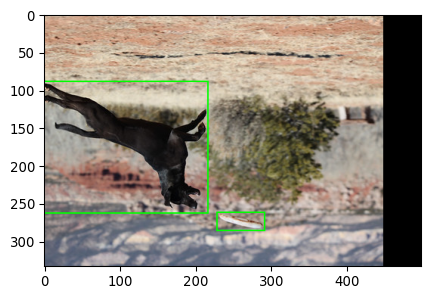

In [63]:
# Plot the results
bbs_aug = BoundingBoxesOnImage([BoundingBox(*box) for box in bbs_aug], img_aug.shape) # Need to convert bounding boxes
ia.imshow(bbs_aug.draw_on_image(img_aug, size=2))

In [64]:
# Apply the augmentation again
img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, im, bbs)

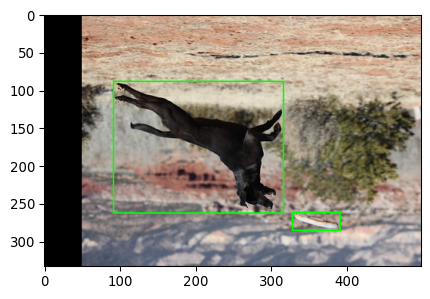

In [65]:
# Plot the results
bbs_aug = BoundingBoxesOnImage([BoundingBox(*box) for box in bbs_aug], img_aug.shape) # Need to convert bounding boxes
ia.imshow(bbs_aug.draw_on_image(img_aug, size=2))

You can see on two different runs of the same sub-policy we get two different results.

Bounding box specific augmentations can also be created. For example let's only solarize the bounding boxes:

In [68]:
def solarize_bbox(magnitude: int) -> iaa.BlendAlphaBoundingBoxes:
    return iaa.BlendAlphaBoundingBoxes(
        None,
        foreground=iaa.pillike.Solarize(threshold=128)
    )   

Any augmentation you would apply to the whole image can also be applied specifically to bounding boxes. All that is required is to return an instance of `BlendAlphaBoundingBoxes` where the `foreground` keyword argument is the augmentation you would like to apply.

In [69]:
policy = [
    [policies.POLICY_TUPLE('Solarize', 1.0, 0)],
]

name_to_augmentation = {
    'Solarize': solarize_bbox,
}

In [70]:
policy_container = policies.PolicyContainer(
    policy,
    name_to_augmentation=name_to_augmentation
)
random_policy = policy_container.select_random_policy()
img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, im, bbs)

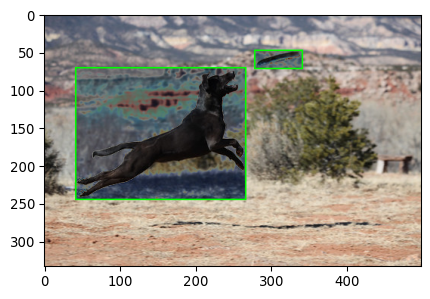

In [71]:
bbs_aug = BoundingBoxesOnImage([BoundingBox(*box) for box in bbs_aug], img_aug.shape) # Need to convert bounding boxes
ia.imshow(bbs_aug.draw_on_image(img_aug, size=2))

We've only applied solarize to the bounding box region.